In [1]:
import copy
import math

from Utilities import *
from PuzzlePiece import *

In [2]:
# gather all the pieces
target_pieces = {}
tried_pieces = {}

for p in ['C','N','NE','E','SE','S','SW','W','NW']:
    target_pieces[p] = Piece('representations/' + p + '_border_ordered.csv', border_sampling_rate=.1)

In [3]:
# get the first piece
query = target_pieces.pop('C') # this piece will grow 
tried_pieces['C'] = copy.deepcopy(query) # keep a copy in case we need to go back 

In [4]:
###############################
# REPEAT HERE
##############################
print(target_pieces.keys())

dict_keys(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


In [5]:
# find the closest match in the other pieces
mx_score = 0
mx_piece = ''

alignments = {}

for i,p in enumerate(target_pieces):
    
    # extend the query to account for circular sequence
    tail_length = min(int(len(target_pieces[p].sampled_pts) * .15),
                  int(len(query.sampled_pts) * .15))

    if i == 0:
        query_ext = copy.deepcopy(query.sampled_pts)
        for i,idx in enumerate(range(len(query.sampled_pts), tail_length)):
            query_ext[len(query.sampled_pts) + i] = copy.deepcopy(query.sampled_pts[i])

    # extend the target to account for circular sequence
    target_ext = {}
    for i,idx in enumerate(range(len(target_pieces[p].sampled_pts) - tail_length,
                                 len(target_pieces[p].sampled_pts))):
        target_ext[i] = { 'orig_idx':target_pieces[p].sampled_pts[idx]['orig_idx'],
                          'x': target_pieces[p].sampled_pts[idx]['x'],
                          'y': target_pieces[p].sampled_pts[idx]['y']}

    for i,idx in enumerate(range(0, len(target_pieces[p].sampled_pts))):
        target_ext[tail_length + i] = \
            { 'orig_idx':target_pieces[p].sampled_pts[idx]['orig_idx'],
              'x': target_pieces[p].sampled_pts[idx]['x'],
              'y': target_pieces[p].sampled_pts[idx]['y']}
    # reverse target for complementarity between query and target
    target_ext_rev = { i:target_ext[i]
                       for i in list(target_ext.keys())[::-1] }
    
    # get the full pairwise matrix to establish the cutoff value
    DistMatrix, mx, mx_Q, mx_T, length = \
        AlignPieces_Euclid(query_ext, target_ext_rev, window = 10)
    
    sims = []
    for i in range(1,len(DistMatrix)):
        for j in range(1,len(DistMatrix[i])):
            sims.append(DistMatrix[i][j])

    sims.sort()
    cutoff = sims[int(len(sims)*.1)]
    
    # Build suffix table from the distance matrix
    distr_score = False
    av = 25
    sd = 5
    
    diy_mx = 0.0
    diy_mx_Q = 0
    diy_mx_T = 0
    
    DIYSuffTable = [[0 for k in range(len(target_ext_rev)+1)] for l in range(len(query_ext)+1)] 
    cutoff_multiplier = 2 # penalty for extended ranges outsisde cutoff
    for i in range(len(query_ext) + 1): 
        for j in range(len(target_ext_rev) + 1): 
            if (i == 0 or j == 0): 
                DIYSuffTable[i][j] = 0
            else:
                d = DistMatrix[i][j]
                if distr_score:
                    qtile = (d-av)/sd
                    if qtile > 0:
                        DIYSuffTable[i][j] = DIYSuffTable[i-1][j-1] - qtile * cutoff_multiplier
                        cutoff_multiplier *= 2
                    else:
                        DIYSuffTable[i][j] = DIYSuffTable[i-1][j-1] - qtile
                        cutoff_multiplier = 2
                else:
                    if d < cutoff: # small distance improve our score
                        DIYSuffTable[i][j] = DIYSuffTable[i-1][j-1] + 1
                        cutoff_multiplier = 1
                    else: #large distances degrade our score
                        DIYSuffTable[i][j] = DIYSuffTable[i-1][j-1] - cutoff_multiplier
                        cutoff_multiplier *= 2
                DIYSuffTable[i][j] = max(0,DIYSuffTable[i][j])

                if DIYSuffTable[i][j] > diy_mx:
                    diy_mx = DIYSuffTable[i][j]
                    diy_mx_Q = i
                    diy_mx_T = j
    
    # determine the length of the best scoring window
    diy_length = 1
    for diy_length in range( 1, min(diy_mx_Q,diy_mx_T)+1 ):
        if DIYSuffTable[diy_mx_Q-diy_length][diy_mx_T-diy_length] == 0:
            break
    diy_length += 1
    
    print('DIY:', p, diy_mx, diy_mx_Q, diy_mx_T, diy_length)
    
    # adjust for possible circular overlap
    if diy_mx_Q >= len(query.sampled_pts):
        diy_mx_Q = diy_mx_Q - len(query.sampled_pts) 
    if diy_mx_T >= len(target_pieces[p].sampled_pts):
        diy_mx_T = diy_mx_T - len(target_pieces[p].sampled_pts)
        
    alignments[p] = { 'SuffTable': DIYSuffTable,
                      'mx_score': diy_mx,
                      'mx_Q': diy_mx_Q,
                      'mx_T': diy_mx_T,
                      'length': diy_length,
                      'cutoff': cutoff}
    
    if diy_mx > mx_score:
        mx_score = diy_mx
        mx_piece = p
        
print('Best: ', mx_piece, mx_score, length)

DIY: N 23 91 83 24
DIY: NE 23 63 94 24
DIY: E 23 91 94 24
DIY: SE 19 46 25 20
DIY: S 20 36 37 21
DIY: SW 17 53 104 18
DIY: W 23 90 76 24
DIY: NW 17 74 77 18
Best:  N 23 2


In [6]:
mx_piece_rev = { i:target_pieces[mx_piece].sampled_pts[i]
                    for i in list(target_pieces[mx_piece].sampled_pts.keys())[::-1] }

mx_alignment = alignments[mx_piece]
SuffTable = mx_alignment['SuffTable']
mx = mx_alignment['mx_score']
mx_Q = mx_alignment['mx_Q']
mx_T = mx_alignment['mx_T']
length = mx_alignment['length']
cutoff = mx_alignment['cutoff']

print(mx_piece, mx, mx_Q, mx_T, length, mx/length)
target = target_pieces.pop(mx_piece)

N 23 91 83 24 0.9583333333333334


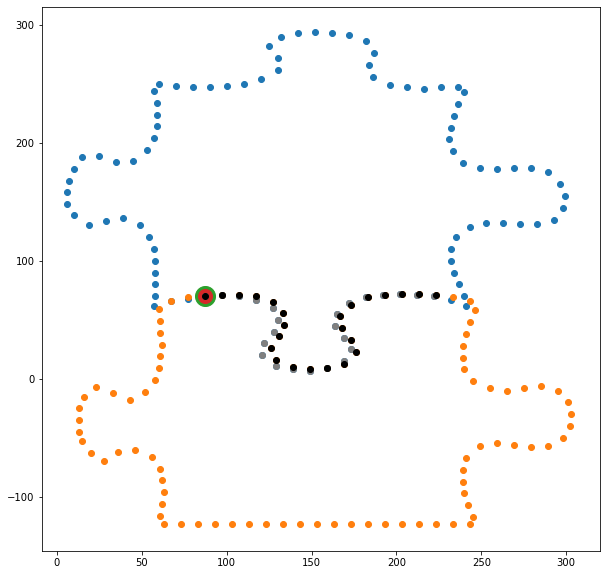

In [7]:
#find the best matched point - this is the end of the best match window
Q_pt = query.sampled_pts[list(query.sampled_pts.keys())[mx_Q-1]]
T_pt = target.sampled_pts[list(target.sampled_pts.keys())[::-1][mx_T-1]] 

# find x,y shift to align pieces
T_xshift = T_pt['x'] - Q_pt['x']
T_yshift = T_pt['y'] - Q_pt['y'] 

plt.figure(figsize = [10,10])
plt.scatter( [query.sampled_pts[k]['x'] for k,v in query.sampled_pts.items() ],
             [query.sampled_pts[k]['y'] for k,v in query.sampled_pts.items() ])
plt.scatter( [target.sampled_pts[k]['x'] - T_xshift for k,v in target.sampled_pts.items() ],
             [target.sampled_pts[k]['y'] - T_yshift for k,v in target.sampled_pts.items() ])

# show best matched points - second will overplot first due to alignment
plt.scatter( Q_pt['x'], Q_pt['y'], s=400)
plt.scatter( T_pt['x'] - T_xshift, T_pt['y'] - T_yshift, s=196 ) 

# show similarity window
# the black and white points repsent the points in the positive scoring diagonal
# of the suffix table starting at the maximum scoring point
# these points are the best locally aligned points
Q_window = [query.sampled_pts[p] for p in list(query.sampled_pts.keys())[ max((mx_Q-length),0):(mx_Q)] ]
plt.scatter( [p['x'] for p in Q_window],
             [p['y'] for p in Q_window], c = 'grey' )
T_window = [target.sampled_pts[p] for p in list(target.sampled_pts.keys())[::-1][(mx_T-length):(mx_T)] ]
plt.scatter( [p['x'] - T_xshift for p in T_window],
             [p['y'] - T_yshift for p in T_window], c = 'black' )

(6, 7) (300, 294)
(6, -125) (301, 294)


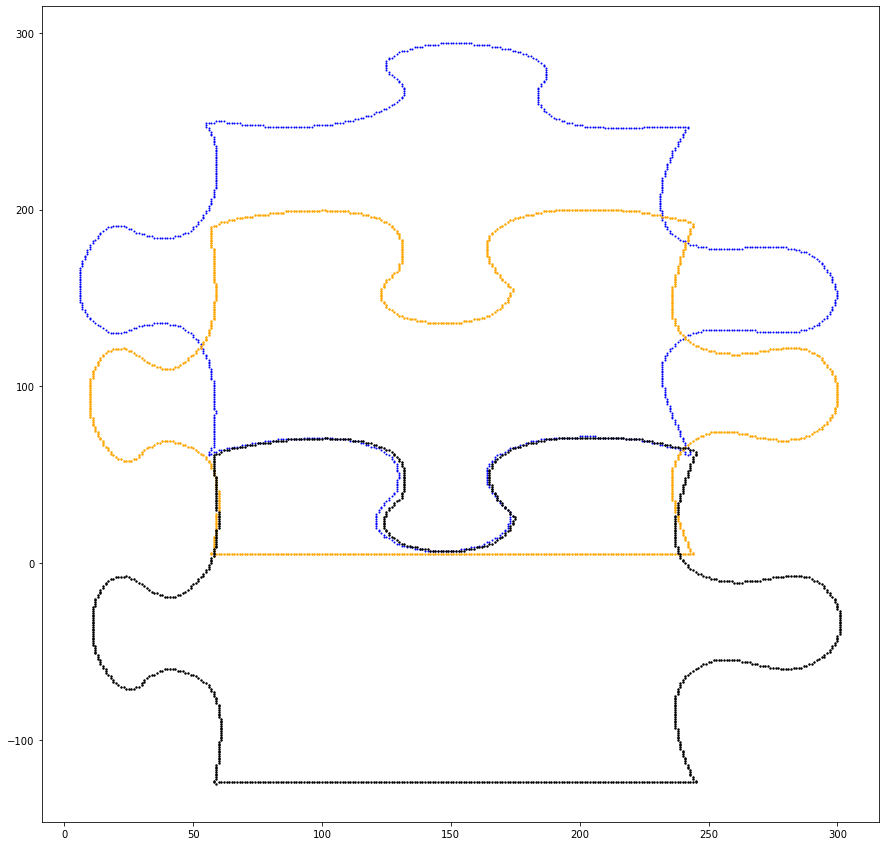

In [8]:
# combine the pieces into one piece

# compute fine alignment over the aligned window
# this is not actually fine tuned - uses sampled_points
Q_window_pts = [q for q in range(mx_Q-length, mx_Q)]
for i,v in enumerate(Q_window_pts):
    if v < 0:
        Q_window_pts[i] += len(query.sampled_pts)
    elif v >=len(query.sampled_pts):
        Q_window_pts[i] -= len(query.sampled_pts)   
Q_window = [query.sampled_pts[q] for q in [list(query.sampled_pts.keys())[i] for i in Q_window_pts]]

T_window_pts = [t for t in range(mx_T-length, mx_T)]
for i,v in enumerate(T_window_pts):
    if v < 0:
        T_window_pts[i] += len(target.sampled_pts)
    elif v >=len(target.sampled_pts):
        T_window_pts[i] -= len(target.sampled_pts)   
T_window = [target.sampled_pts[t] for t in [list(target.sampled_pts.keys())[::-1][i] for i in T_window_pts]]

T_xshift = int((sum([p['x'] for p in Q_window]) - sum([p['x'] for p in T_window])) / length)
T_yshift = int((sum([p['y'] for p in Q_window]) - sum([p['y'] for p in T_window])) / length)

# for all original points in target shifted by fine alignment:
    # add to query with OR function for collisions

# piece points currently in dictionary:  { pt#: {'x':x, 'y':y} }
# convert to 2d array indexed by x and y
Q_pt_array = {}
for p in query.pts.items():
    Q_pt_array[p[1]['x']] = {p[1]['y']:1}
    
Q_pt_array = {}
Q_orig_x = []
Q_orig_y = []

min_x = 999999
min_y = 999999
max_x = -999999
max_y = -999999

for p in query.pts.items():
    if p[1]['x'] not in Q_pt_array.keys():
        Q_pt_array[p[1]['x']] = []   
    Q_pt_array[p[1]['x']].append(p[1]['y'])
    Q_orig_x.append(p[1]['x'])
    Q_orig_y.append(p[1]['y'])
    if p[1]['x'] < min_x:
        min_x = p[1]['x']
    if p[1]['x'] > max_x:
        max_x = p[1]['x']
    if p[1]['y'] < min_y:
        min_y = p[1]['y']
    if p[1]['y'] > max_y:
        max_y = p[1]['y']
    
print((min_x, min_y), (max_x, max_y))

T_orig_x = []
T_orig_y = []
T_shifted_x = []
T_shifted_y = []

for p in target.pts.items():
    if p[1]['x'] + T_xshift not in Q_pt_array.keys():
        Q_pt_array[p[1]['x'] + T_xshift] = []   
    Q_pt_array[p[1]['x'] + T_xshift].append(p[1]['y'] + T_yshift)
    T_orig_x.append(p[1]['x'])
    T_orig_y.append(p[1]['y'])
    T_shifted_x.append(p[1]['x'] + T_xshift)
    T_shifted_y.append(p[1]['y'] + T_yshift)
    if p[1]['x'] + T_xshift < min_x:
        min_x = p[1]['x'] + T_xshift
    if p[1]['x'] + T_xshift > max_x:
        max_x = p[1]['x'] + T_xshift
    if p[1]['y'] + T_yshift < min_y:
        min_y = p[1]['y'] + T_yshift
    if p[1]['y'] + T_yshift > max_y:
        max_y = p[1]['y'] + T_yshift
    
plt.figure(figsize = [15,15])
plt.scatter( Q_orig_x, Q_orig_y, c = 'blue', s=1)
plt.scatter( T_orig_x, T_orig_y, c = 'orange', s=2)
plt.scatter( T_shifted_x, T_shifted_y, c = 'black', s=2)

print((min_x, min_y), (max_x, max_y))

(-4, -135) (311, 304)


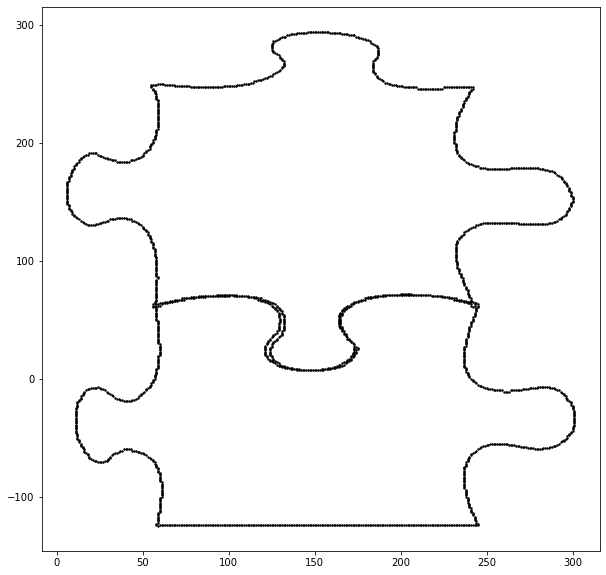

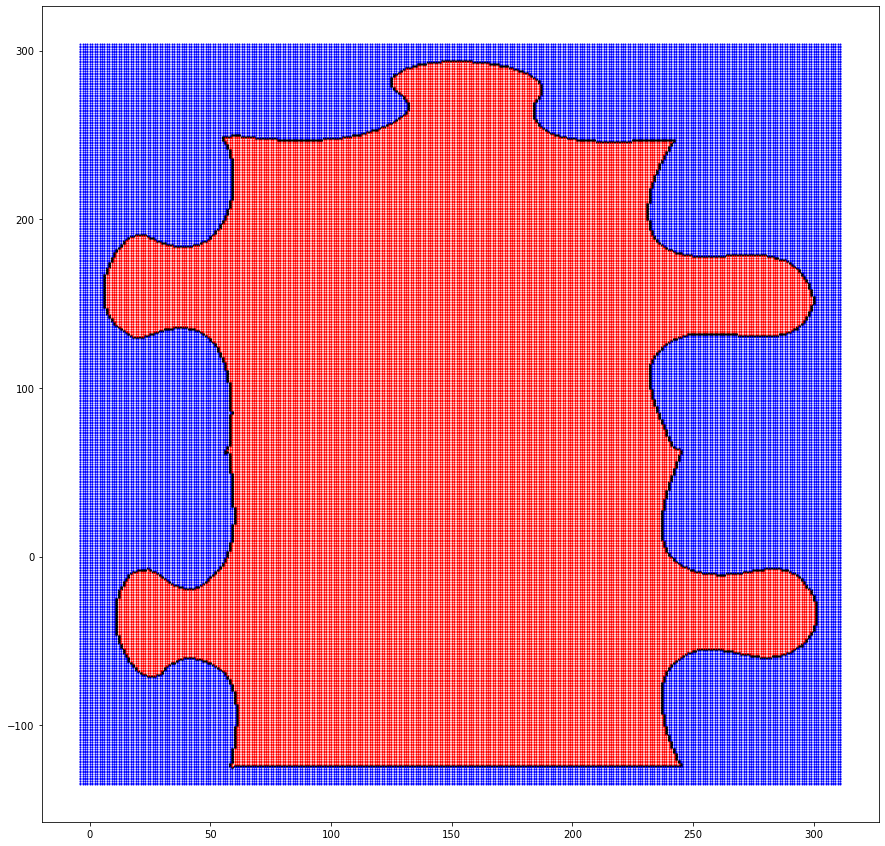

In [9]:
# compute new boundary
# floodfill from exploratory 02 
#convert sparse array to piece_coords complete array
piece_coords = dict()
composite_x = []
composite_y = []

for x in range(min_x-10, max_x+11):
    for y in range(min_y-10, max_y+11):
        if x not in piece_coords:
            piece_coords[x] = dict()

        if y not in piece_coords[x]:
            piece_coords[x][y] = dict()

        v = 1 # default to white point
        if x in Q_pt_array:
            if y in Q_pt_array[x]:
                v = 0 # black point
                composite_x.append(x)
                composite_y.append(y)

        piece_coords[x][y] = {'value': v,
                              'left':None,
                              'right':None,
                              'up':None,
                              'down':None,
                              'visited':False,
                              'outer_border':False}

min_x = min(piece_coords.keys())
max_x = max(piece_coords.keys())
min_y = min(piece_coords[min_x].keys())
max_y = max(piece_coords[min_x].keys())

print((min_x, min_y), (max_x, max_y))

plt.figure(figsize = [10,10])
plt.scatter( composite_x, composite_y, c = 'black', s=2)

# create a place to store (x,y) coordinates
outer_border = list()

# link up the list
for x in range(min_x, max_x+1):
    for y in range(min_y, max_y+1):
        if x > min_x:
            piece_coords[x][y]['left'] = (x-1, y)
        if x < max_x:
            piece_coords[x][y]['right'] = (x+1, y)
        if y > min_y:
            piece_coords[x][y]['down'] = (x, y-1)
        if y < max_y:
            piece_coords[x][y]['up'] = (x, y+1)
            
# start flooding
curr_x = min_x
curr_y = min_y
stack = list()

while True:
    curr_node = piece_coords[curr_x][curr_y]
    curr_node['visited'] = True
    
    # check for black
    if curr_node['value'] == 0:
        curr_node['outer_border'] = True
        (curr_x, curr_y) = stack.pop()
        continue
        
    # try to exapnd right
    if curr_node['right'] is not None:
        stack.append( (curr_x, curr_y) )
        (curr_x, curr_y) = curr_node['right']
        curr_node['right'] = None
        continue
    if curr_node['down'] is not None:
        stack.append( (curr_x, curr_y) )
        (curr_x, curr_y) = curr_node['down']
        curr_node['down'] = None
        continue
    if curr_node['left'] is not None:
        stack.append( (curr_x, curr_y) )
        (curr_x, curr_y) = curr_node['left']
        curr_node['left'] = None
        continue
    if curr_node['up'] is not None:
        stack.append( (curr_x, curr_y) )
        (curr_x, curr_y) = curr_node['up']
        curr_node['up'] = None
        continue
    
    # if all directions fail, back up one if possible
    if len(stack) == 0:
        break
    else:
        (curr_x, curr_y) = stack.pop()

# inside, outside, and border
inside_x = []
inside_y = []
outside_x = []
outside_y = []
border_x = []
border_y = []

for x in piece_coords.keys():
    for y in piece_coords[x].keys():
        if piece_coords[x][y]['outer_border']:
            border_x.append(x)
            border_y.append(y)
        else:
            if piece_coords[x][y]['visited']:
                outside_x.append(x)
                outside_y.append(y)
            else:
                inside_x.append(x)
                inside_y.append(y)

plt.figure(figsize = [15,15])
plt.scatter( border_x, border_y, c = 'black', s=4)
plt.scatter( outside_x, outside_y, c = 'blue', s=1)
plt.scatter( inside_x, inside_y, c = 'red', s=1)

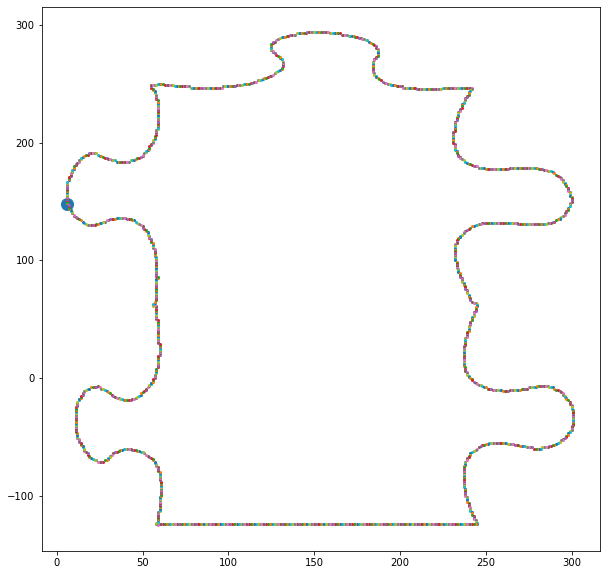

In [10]:
# put boundary points in order
# from exploratory 3

border = dict()

for i,(x,y) in enumerate(zip(border_x, border_y)):
    border[i] = { 'x':x,
                  'y':y, 
                  'order':None }


# create dictionary to hold order of points by key
k = border.keys()
dist_mat = [[999999 for i in range(len(k))] for j in range(len(k))] 

for i in range(0,len(k)-1):
    for j in range(i+1,len(k)):
        x1 = border[i]['x']
        x2 = border[j]['x']
        y1 = border[i]['y']
        y2 = border[j]['y']
        d = math.sqrt( (x1-x2)**2 + (y1-y2)**2 )
        dist_mat[i][j] = d
        dist_mat[j][i] = d

# set first point
current_pt = 0
ordered_pts = []
early_stop = False

# step through points finding the closest to create the border order
for i in range(len(k)):
    border[current_pt]['order'] = i
    ordered_pts.append(current_pt)
    
    li=[] 
    for j in range(len(dist_mat[current_pt])): 
          li.append([dist_mat[current_pt][j],j]) 
    li.sort() 
    sort_index = [] 
      
    for x in li: 
          sort_index.append(x[1]) 

    for j,dist_idx in enumerate(sort_index):
        if dist_idx == 0 and j != 0:
            early_stop = True
            break 
        
        if border[dist_idx]['order'] is None:
            current_pt = dist_idx
            break
        
    if early_stop:
        break

plt.figure(figsize=[10,10])
new_pts = {}
for i,o in enumerate(ordered_pts):
    new_pts[i] = { 'x':border[o]['x'],
                   'y':border[o]['y']}
    
    if i == 0:
        z = 144
    else:
        z = 4
    plt.scatter(border[o]['x'], border[o]['y'], s = z)
                 
query.pts = copy.deepcopy(new_pts)

In [11]:
# resample boundary
query.sample_border(sampling_rate=.2)

In [12]:
# recompute distances, etc.
# already in PuzzlePiece.py
query.create_border_distances()

In [13]:
#########################
# REPEAT ABOVE
#########################